In [1]:
import polars as pl
import requests
import zipfile
import matplotlib.pyplot as plt
import time
import io

In [2]:
# Read CSV
url = 'https://github.com/mattharrison/datasets/raw/master/data/names-ss-1910-2022.csv.zip'

# Download the zip file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read the CSV file inside the zip
csv_filename = zip_file.namelist()[0]  # Get the name of the CSV file in the zip
with zip_file.open(csv_filename) as csv_file:
    names = pl.read_csv(csv_file)

In [3]:
start = time.time()
# Create movie names DataFrame
actor_names = [
    "Primrose", "Anakin", "Arwen", "Esme", "Amelie", "Keanu", "Kylo",
    "Coraline", "Leia", "Meadow", "Adele", "Elsa", "Augustus", 
    "Xander", "Maximus", "Arya", "Ariel", "Chandler", "Luna"
]

movies = [
    "The Hunger Games", "Star Wars", "The Lord of the Rings", "New Moon", 
    "Amelie", "John Wick", "Star Wars", "Coraline", "Star Wars: A New Hope",
    "The Sopranos", "21", "Frozen", "The Fault in Our Stars", 
    "Buffy the Vampire Slayer", "Gladiator", "Game of Thrones", 
    "The Little Mermaid", "Friends", "Harry Potter and the Order of the Phoenix"
]

years = [
    2012, 1999, 2001, 2006, 2001, 2014, 2015, 2009, 1977,
    1999, 2010, 2013, 2014, 1997, 2000, 2011, 1989, 1994, 2007
]

movie_names = pl.DataFrame({
    'Name': actor_names,
    'Movie': movies,
    'Year': years
})
movie_names

Name,Movie,Year
str,str,i64
"""Primrose""","""The Hunger Games""",2012
"""Anakin""","""Star Wars""",1999
"""Arwen""","""The Lord of the Rings""",2001
"""Esme""","""New Moon""",2006
"""Amelie""","""Amelie""",2001
…,…,…
"""Maximus""","""Gladiator""",2000
"""Arya""","""Game of Thrones""",2011
"""Ariel""","""The Little Mermaid""",1989


/tmp/ipykernel_560499/1543284211.py:7: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


<Axes: >

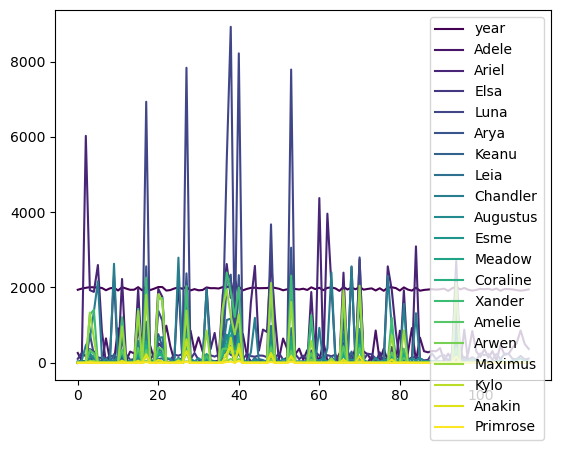

In [4]:
# First plot
result = (
    names
    .join(movie_names, left_on='name', right_on='Name', how='inner')
    .group_by(['year', 'name'])
    .agg(pl.col('count').sum())
    .pivot(
        values='count',
        index='year',
        columns='name',
        aggregate_function='sum'
    )
    .fill_null(0)
)
# Convert to pandas for plotting (as Polars doesn't have direct plotting capabilities)
result.to_pandas().plot(cmap='viridis')

1.3201251029968262


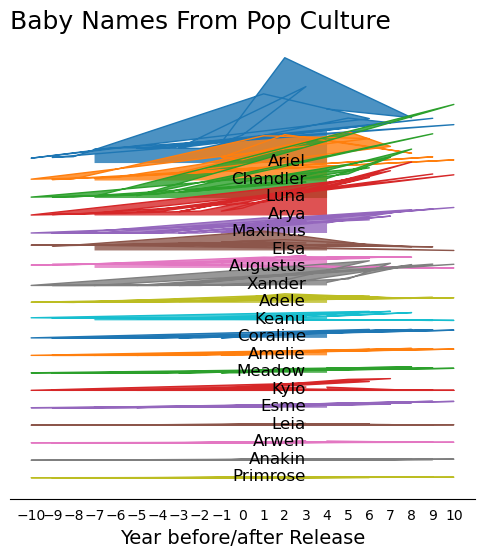

In [5]:
# Helper function for the second plot
def plot_fill(df_, factor=100, figsize=(8,3), alpha=.8):
    fig, ax = plt.subplots(figsize=figsize)
    for i, col in enumerate(df_.columns):
        ax.plot(df_.index, df_[col] + (i*factor), linewidth=1)
        ax.fill_between(df_.index, y1=[(i*factor)] * len(df_), y2=df_[col] + (i*factor), alpha=alpha)
        ax.text(df_.index[0] -1, (i*factor) + 100, col, fontsize=12, ha='right', va='center')

    for side in ['right', 'top', 'left']:
        ax.spines[side].set_visible(False)

    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticks([])
    ax.set_xticks(range(-10,11))
    ax.set_title('Baby Names From Pop Culture', loc='left', fontsize=18)
    ax.set_xlabel('Year before/after Release', fontsize=14)
    return df_

# Second plot
result2 = (
    names
    .join(movie_names, left_on='name', right_on='Name', how='inner')
    .with_columns(
        (pl.col('year') - pl.col('Year')).alias('year_offset')
    )
    .filter(
        (pl.col('year_offset') >= -10) & (pl.col('year_offset') <= 10)
    )
    .group_by(['year_offset', 'name'])
    .agg(pl.col('count').sum())
    .pivot(
        values='count',
        index='year_offset',
        on='name',
        aggregate_function='sum'
    )
    .fill_null(0)
)

# Get column names (excluding 'year_offset')
cols = [col for col in result2.columns if col != 'year_offset']

# Calculate sums for each column
sums = {col: result2[col].sum() for col in cols}

# Sort columns by their sums
sorted_cols = sorted(cols, key=lambda x: sums[x], reverse=True)

# Reorder columns with year_offset first, then sorted columns
result2 = result2.select(['year_offset'] + sorted_cols)

# Convert to pandas for plotting
plot_fill(result2.to_pandas().set_index('year_offset'), factor=-1000, figsize=(6,6))

end = time.time() - start
print(end)